# Azure ML Pipelines

Цель лабораторной работы: 

- публикация __Конвейеров машинного обучения__ (ML Pipelines) в Azure ML
- планирование выполнения Конвейеров машинного обучения.

## Подготовка среды

Импорт необходимых модулей и проверка версии AzureML SDK:

In [19]:
import azureml.core
from azureml.core import Workspace

# Check core SDK version number
print(f'SDK version: {azureml.core.VERSION}')

SDK version: 1.14.0


Получим конфигурацию эксперимента: 

In [6]:
%run core.py

config = get_experiment_config('lab_6B')
config

{'experiment_name': 'pipeline-experiment',
 'core': {'expriments_root_dir': 'experiments/',
  'datastore_name': 'aml_ws_datastore_v2',
  'dataset_name': 'diabetes-data',
  'ml_cluster_name': 'aml-ws-cluster',
  'ml_model_name': 'diabetes-predict-model'}}

## Соединение со Azure ML Workspace

Устанавливаем соединение с Рабочей областью в Azure ML:

In [4]:
ws = Workspace.from_config()
print(f'Successfully connected to Workspace: {ws.name}.')

Successfully connected to Workspace: aml-workshop.


## Публикация ML Конвейера

После того как Вы создали ML Конвейер, Вы можете опубликовать его в качестве REST-сервиса. 
Вы запустили ML Конвейер в [предыдущей лаборатории](06A-creating-pipelines.ipynb). Используйте ссылку на этот запуск для публикации ML Конвейера.

In [ ]:
# Get the most recent run of the pipeline
pipeline_experiment = ws.experiments.get(config['experiment_name'])
pipeline_run = list(pipeline_experiment.get_runs())[0]

print(f'Recent run info: {pipeline_run}')

In [ ]:
# Publish the pipeline from the run
pipeline = pipeline_run.publish_pipeline(name='diabetes-model-train-pipeline',
                                         description='Diabetes model training pipeline',
                                         version='1.0')

pipeline

Для опубликованного ML Конвейера была создана Конечная точка (Endpoint), которую также можно увидеть на странице Конечные точки (на вкладке Конечные точки конвейера) на портале Azure ML. 
URI Конечной точки также доступно как свойство опубликованного ML Конвейера:

In [ ]:
print(f'Pipeline name: {pipeline.name} \nEndpoint URI: {pipeline.endpoint}')

## Использование Конечной точки ML Конвейера

Чтобы использовать Конечную точку, нужно выполнить вызов REST по протоколу HTTP. Этот запрос должен быть аутентифицирован, поэтому требуется заголовок авторизации (authentication header). Получим это заголовок:

In [11]:
from azureml.core.authentication import InteractiveLoginAuthentication

auth = InteractiveLoginAuthentication()
auth_header = auth.get_authentication_header()

print('Authentication Header is ready.')

Authentication Header is ready.


Запустим выполнение ML Конвейера: 

In [12]:
import requests

response = requests.post(pipeline.endpoint, 
                         headers=auth_header, 
                         json={'ExperimentName': config['experiment_name']})

run_id = response.json()['Id']
print(f'Run id: {run_id}')

Run id: abca1e7c-2d1a-45ce-9eda-f3e2423f7006


Идентификатор запуска Вам вернулся мнгновенно, но это не означает, что ML Конвейер уже выполнился. 

Посмотрите через портал Azure ML или с помощью Azure ML SDK за статусом запуска ML Конвейера:

In [ ]:
from azureml.pipeline.core.run import PipelineRun

pipeline_run = PipelineRun(ws.experiments[config['experiment_name']], run_id)
pipeline_run.wait_for_completion(show_output=True)

## Планирование выполнения запусков ML Конвейера

Предположим, что клиника для больных сахарным диабетом собирает новые данные каждую неделю и добавляет их в набор данных. Вы можете запускать конвейер каждую неделю, чтобы переобучить модель с новыми данными.

In [16]:
from azureml.pipeline.core import ScheduleRecurrence, Schedule

# Submit the Pipeline every Monday at 00:00 UTC
recurrence = ScheduleRecurrence(frequency='Week', interval=1, week_days=['Monday'], time_of_day='00:00')

weekly_schedule = Schedule.create(ws, 
                                  name='weekly-diabetes-model-train-pipeline', 
                                  description="Weekly Diabetes Model Training Pipeline",
                                  pipeline_id=pipeline.id, 
                                  experiment_name=config['experiment_name'], 
                                  recurrence=recurrence)

print('Pipeline was scheduled.')

Pipeline was scheduled.


Получим список запланированных запусков:

In [ ]:
Schedule.list(ws)

Просмотрите на портале Azure ML список выполненных и запланированных ML Конвейров.

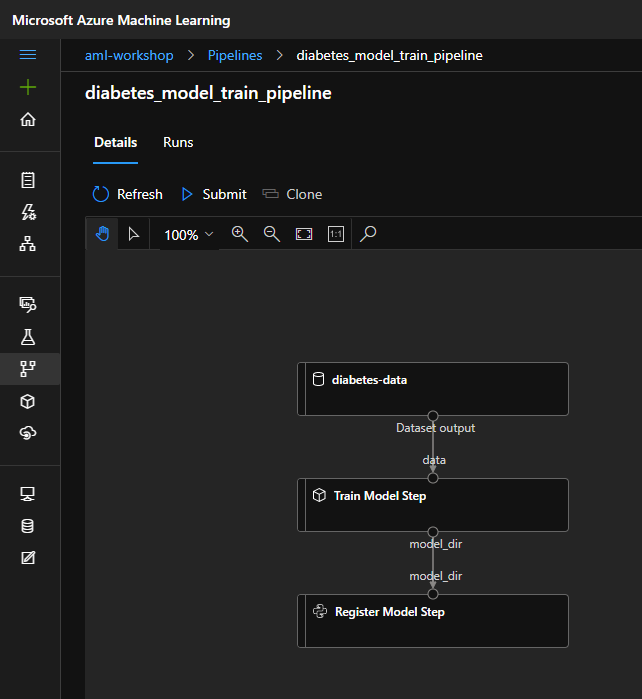